**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/01_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/01_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
!pip install scikit-learn -U -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 49.4 MB/s eta 0:00:00


Remember to restart the notebook to update the modules

In [ ]:
# Python ≥3.7 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.2 is recommend
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
import os
import tarfile
import urllib.request


# To plot pretty figures # This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend.
# https://github.com/pycaret/pycaret/issues/319
%matplotlib inline
%config InlineBackend.figure_format = 'svg'    
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set_context("notebook")

# Where to save the figures
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Get the Data

## Download the Data

It is preferable to create a small function to do that. It is useful in particular 

1. If data changes regularly, as it allows you to write a small script that you can run whenever you need to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals).
2. Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.


 



Here is the function to fetch and load the data:

In [ ]:
def load_housing_data():
    """When load_housing_data() is called, it looks for the datasets/housing.tgz file. If it
    does not find it, it creates the datasets directory inside the current directory
    downloads the housing.tgz file from the ageron/data GitHub repository, 
    and extracts its content into the datasets directory
    """
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

## Take a Quick Look at the Data Structure

Now let’s load the data using `Pandas`. Once again you should write a small function to load the data:

In [ ]:
housing = load_housing_data()

https://www.kaggle.com/camnugent/california-housing-prices

In [ ]:
#Let’s take a look at the top five rows.
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes

In [ ]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values
housing.info(), housing.shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(None, (20640, 10))

Notice that the `total_bedrooms` attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are numerical, except for `ocean_proximity`. Its type is object, so it could hold any kind of Python object. But since you loaded this data from a CSV file, you know that it must be a text attribute. When you looked at the top five rows, you probably noticed that the values in the `ocean_proximity` column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the `value_counts()` method.

In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Note that the null values are ignored below (so, for example, count of `total_bedrooms` is 20,433, not 20,640).

In [ ]:
housing.describe() # The describe() method shows a summary of the numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis).

You can either plot this one attribute at a time, or you can call the `hist()` method on the whole dataset (dataframe), and it will plot a histogram
for each numerical attribute:

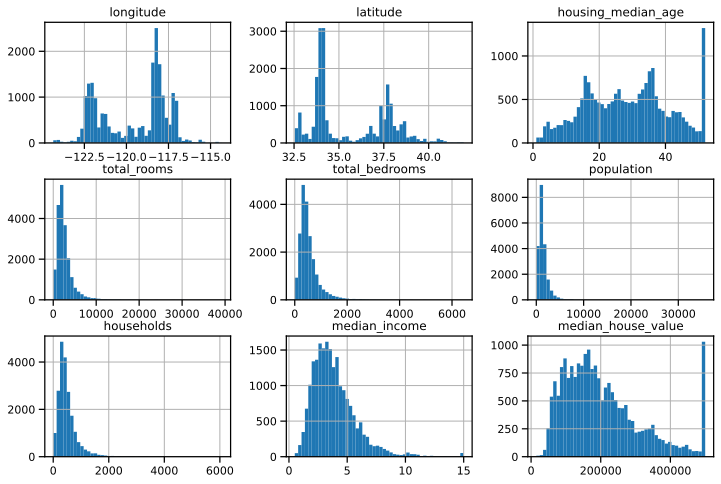

In [ ]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have mainly two options:

* Collect proper labels for the districts whose labels were capped.
* Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond
$500,000).

3. These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.

4. Finally, many histograms are heavy tail and skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Create a Test Set

To avoid the **data snooping bias**. Creating a test set! This is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside

In [ ]:
# to make this notebook's output identical at every run
# https://en.wikipedia.org/wiki/42_(number)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
len(train_set)

16512

In [ ]:
len(test_set)

4128

In [ ]:
test_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN
13311,-121.76,36.92,36.0,2096.0,409.0,1454.0,394.0,3.2216,238300.0,<1H OCEAN
7113,-120.45,34.91,16.0,712.0,147.0,355.0,162.0,2.5600,150000.0,<1H OCEAN
7668,-117.86,33.79,31.0,3523.0,922.0,2660.0,949.0,3.1792,146400.0,<1H OCEAN
18246,-117.43,33.91,15.0,14281.0,2511.0,7540.0,2245.0,4.3222,138000.0,INLAND
5723,-118.18,34.13,44.0,2734.0,415.0,1057.0,424.0,7.9213,477800.0,<1H OCEAN


### Optional

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are **representative** of the whole population. 

For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the **test set is representative of the overall population**. If they used purely random sampling, the survey results may be significantly biased.

**Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices**. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely. 

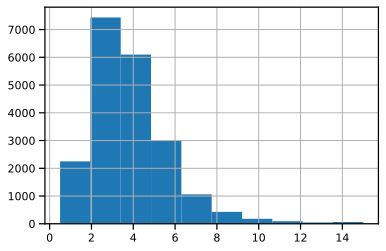

In [ ]:
housing["median_income"].hist()
plt.show()

Most median income values are clustered around 1.5 to 6 (i.e., $15,000 – $60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you **should not have too many strata**, and each stratum should be large enough. The following code uses the `pd.cut()` function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

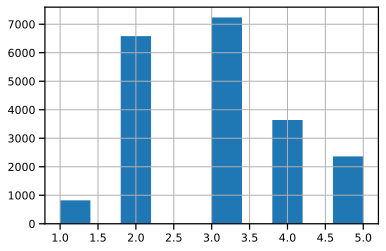

In [ ]:
housing["income_cat"].hist()
plt.show()

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s `StratifiedShuffleSplit` class:

https://scikit-learn.org/stable/modules/cross_validation.html#stratified-shuffle-split

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Let’s see if this worked as expected. You can start by looking at the income category proportions in the test set:

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

With similar code you can measure the income category proportions in the full dataset. Below we compare the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"]/compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"]/compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


You won’t use the income_cat column again, so you might as well drop it, reverting the data back to its original state:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

Let’s create a copy so you can play with it without harming the training set

In [ ]:
housing = strat_train_set.copy()
#housing = train_set.copy()

## Visualizing Geographical Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

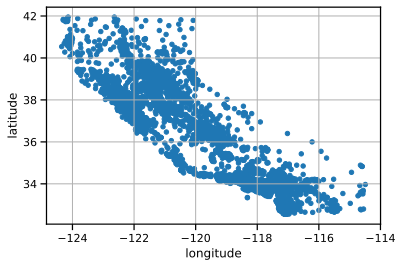

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.2 makes it much easier to visualize the places where there is a **high density of data points**

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")

Output hidden; open in https://colab.research.google.com to view.

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high-density areas in the Central Valley.

Now let’s look at the housing prices (Figure 2-13). The radius of each circle represents the district’s population (option `s`), and the color represents the price (option `c`). We will use a predefined color map (option `cmap`) called `jet`, which ranges from blue (low values) to red (high prices):

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ).

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s= housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already.

It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the **proximity to the cluster centers**. The `ocean proximity` attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

In [ ]:
# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes

In [ ]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; For example, the median house value tends to go up when the median income goes up. 

When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). 

Finally, coefficients close to zero mean that there is no linear correlation. It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”)

Another way to check for correlation between attributes is to use Pandas’ `scatter_matrix` function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 121 plots (including index), which would not fit on a page, so let’s just focus on a few promising attributes that seem most correlated with the median housing value

In [ ]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
plt.figure(figsize=[12,8])
sns.pairplot(housing[attributes])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.axis([0, 16, 0, 550000])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

This plot reveals a few things. 

1. First, the correlation is indeed very strong; you can clearly see the upward 
trend and the points are not too dispersed. 

2. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at `$500,000`. But this plot reveals other less obvious straight lines: a horizontal line around `$450,000`, another around `$350,000`, perhaps one around `$280,000`, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

## Experimenting with Attribute Combinations

Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. 

* We identified a few data quirks that you may want to clean up before feeding the data to a machine learning algorithm
* We found interesting correlations between attributes, in particular with the target attribute
* We also noticed that some attributes have a skewed-right distribution, so you may want to transform them (e.g., by computing their logarithm or square root). 

Of course, your mileage will vary considerably with each project, but the general ideas are similar.

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. 

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. 

Let’s create these new attributes:

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

And now let’s look at the correlation matrix again:

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_ratio             -0.256397
Name: median_house_value, dtype: float64

Hey, not bad! The new `bedrooms_ratio` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. **The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.**

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an **iterative process**: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

# Prepare the Data for Machine Learning Algorithms

Let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect `strat_train_set`):

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set X
housing_labels = strat_train_set["median_house_value"].copy() # y

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the `total_bedrooms` attribute has some missing values, so let’s fix this. You have three options:

* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value (zero, the mean, the median, etc.).

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
366,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,NEAR OCEAN
18241,-121.44,38.54,39.0,2855.0,NaN,1217.0,562.0,3.2404,INLAND
18493,-116.21,33.75,22.0,894.0,NaN,830.0,202.0,3.0673,INLAND


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN
...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
366,-122.50,37.75,44.0,1819.0,1137.0,354.0,3.4919,NEAR OCEAN
18241,-121.44,38.54,39.0,2855.0,1217.0,562.0,3.2404,INLAND
18493,-116.21,33.75,22.0,894.0,830.0,202.0,3.0673,INLAND


In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,434.0,954.0,397.0,3.7813,<1H OCEAN
366,-122.50,37.75,44.0,1819.0,434.0,1137.0,354.0,3.4919,NEAR OCEAN
18241,-121.44,38.54,39.0,2855.0,434.0,1217.0,562.0,3.2404,INLAND
18493,-116.21,33.75,22.0,894.0,434.0,830.0,202.0,3.0673,INLAND


If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to **save the median value** that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

`Scikit-Learn` provides a handy class to take care of missing values: `SimpleImputer`.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you then need to
create a copy of the data with only the numerical attributes (this will exclude the text attribute `ocean_proximity`)

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

> All objects in SKlearn share a consistent and simple interface:
> 1. **Estimators**: Any object that can estimate some parameters based on a dataset is called an estimator (e.g., a `SimpleImputer` is an estimator). The estimation itself is performed by the `fit()` method, and it takes a dataset as a parameter, or two for supervised learning algorithms—the second dataset contains the labels. Any other parameter needed to guide the estimation process is considered a hyperparameter (such as a `SimpleImputer`’s strategy), and it must be set as an instance variable (generally via a constructor parameter).
> 2. **Transformers**: Some estimators (such as a `SimpleImputer`) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for a `SimpleImputer`. All transformers also have a convenience method called `fit_transform()`, which is equivalent to calling `fit()` and then `transform()` (but sometimes `fit_transform()` is optimized and runs much faster).
> 3. **Predictors**: Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. For example, the `LinearRegression` model was a predictor. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

> As with all estimators, it is important to fit the scalers to the training
data only: never use `fit()` or `fit_transform()` for anything else than the training set. Once you have a trained scaler, you can then use it to `transform()` any other set, including the validation set, the test set, and new data.

The imputer has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing values, **but we cannot be sure that there won’t be any missing values in new data after the system goes live**, so it is safer to apply the imputer to all the numerical attributes:

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [ ]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:

In [ ]:
#housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
from sklearn import config_context
with config_context(transform_output="pandas"):
    housing_tr = imputer.transform(housing_num)

See https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html#sphx-glr-auto-examples-miscellaneous-plot-set-output-py

In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


## Dealing with outlier (Optional)

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

If you wanted to drop outliers, you would run the following code:

In [ ]:
outlier_pred

In [ ]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but your data may also contain text attributes. In this dataset, there is just one: the `ocean_proximity` attribute. Let’s look at its value for the first few instances:

In [ ]:
housing_cat = housing[["ocean_proximity"]] # Note the double square bracket
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

You can get the list of categories using the `categories_` instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will **assume that two nearby values are more similar than two distant values**. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the `ocean_proximity` column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). 

To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a `OneHotEncoder` class to convert categorical values into one-hot vectors

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The advantage of `OneHotEncoder` over `get_dummies()` is that 

1. It remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training: no more, no less. 

2. `OneHotEncoder` is smarter: it will detect the unknown category and raise
an exception. If you prefer, you can set the `handle_unknown` hyperparameter to
`"ignore"`, in which case it will just represent the unknown category with zeros

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [ ]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species, etc.), then one-hot encoding will result in a large number of input features. **This may slow down training and degrade performance**. 

If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the
`ocean_proximity` feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). 

Alternatively, you could replace each category with a learnable low dimensional vector called an embedding. Each category’s representation would be learned during training: this is an example of **representation learning**.

When you fit any Scikit-Learn estimator using a DataFrame, the estimator stores the column names in the `feature_names_in_` attribute. Scikit-Learn then ensures that any DataFrame fed to this estimator after that (e.g., to `transform()` or `predict()`) has the same column names. Transformers also provide a `get_feature_names_out()` method that you can use to build a DataFrame around the transformer’s output:

In [ ]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## Feature Scaling and Transformation

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms.

### Min-max scaling

Min-max scaling (many people call this **normalization**) is the simplest: for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. This is performed by subtracting the min value and dividing by the difference between the min and the max. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if, for some reason, you don’t want 0–1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

### Standardization

Standardization is different: first it subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standardized values have a standard deviation equal to 1). Unlike min-max scaling, standardization does not restrict values to a specific range. **However, standardization is much less affected by outliers**.

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

### Other scaling (Optional)

When a feature’s distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization will squash most values into a small range. Machine learning models generally don’t like this at all. So before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly
symmetrical. For example, a common way to do this for positive features with a heavy tail to the right is to replace the feature with its **square root** (or raise the feature to a power between 0 and 1). If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its **logarithm** may help.

For example, the population feature roughly follows a power law

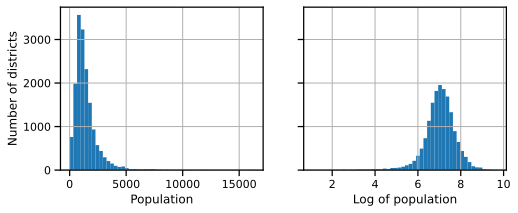

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

Another approach to handle heavy-tailed features consists in **bucketizing** the feature. This means chopping its distribution into roughly equal-sized buckets, and replacing each feature value with the index of the bucket it belongs to. For example, you could replace each value with its percentile. Bucketizing with equal-sized buckets results in a feature with an almost uniform distribution, so there’s no need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.

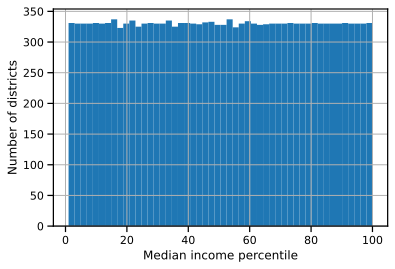

In [ ]:
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"], bins=[-np.inf] + percentiles + [np.inf], labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

> When a feature has a multimodal distribution (i.e., with two or more clear peaks, called modes), such as the `housing_median_age` feature, it can also be helpful to bucketize it, **but this time treating the bucket IDs as categories**, rather than as numerical values. This means that the bucket indices must be encoded, for example using a `OneHotEncoder` (so you usually don’t want to use too many buckets). This approach will allow the regression model to more easily learn different rules for different ranges of this feature value. 

For example, perhaps houses built around 35 years ago have a peculiar style that fell out of fashion, and therefore they’re cheaper than their age
alone would suggest.

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF). Using Scikit-Learn’s `rbf_kernel()` function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

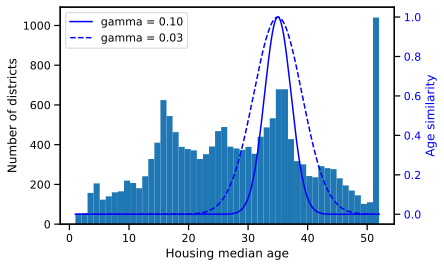

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

As the chart shows, the new age similarity feature peaks at 35, right around the spike in the housing median age distribution: if this particular age group is well correlated with lower prices, there’s a good chance that this new feature will help.

## Custom Transformers

Although `Scikit-Learn` provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific
attributes.

### Function with no training parameter (Optional)

For transformations that don’t require any training, you can just write a function that takes a NumPy array as input and outputs the transformed. Let’s create a log-transformer and apply it to the `population` feature:

In [ ]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

### Transform with training parameter

`FunctionTransformer` is very handy, but what if you would like your transformer to be trainable, learning some parameters in the `fit()` method and using them later in the `transform()` method? You can get `fit_transform()` for free by simply adding `TransformerMixin` as a base class: the default implementation will just call `fit()` and then `transform()`. If you
add `BaseEstimator` as a base class (and avoid using `*args` and `**kwargs` in your constructor), you will also get two extra methods: `get_params()` and `set_params()`. These will be useful for automatic hyperparameter tuning.

For example, the following code demonstrates custom transformer that uses a
KMeans clusterer in the `fit()` method to identify the main clusters in the training data, and then uses `rbf_kernel()` in the `transform()` method to measure how similar each sample is to each cluster center:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

K-means is a clustering algorithm that locates clusters in the data. How many it searches for is controlled by the `n_clusters` hyperparameter. After training, the cluster centers are available via the `cluster_centers_` attribute. The `fit()` method of KMeans supports an optional argument `sample_weight`, which lets the user specify the relative weights of the samples. k-means is a stochastic algorithm, meaning that it relies on randomness to locate the clusters, so if you want reproducible results, you must set the `random_state` parameter. As you can see, despite the complexity of the task, the code is fairly straightforward. Now let’s use this
custom transformer:

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


This code creates a `ClusterSimilarity` transformer, setting the number of clusters to 10. Then it calls `fit_transform()` with the latitude and longitude of every district in the training set, weighting each district by its median house value. The transformer uses k-means to locate the clusters, then measures the Gaussian RBF similarity between each district and all 10 cluster centers. The result is a matrix with one row per district, and one column per cluster.

> See https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means for the rationale of using clustering results as features.

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The figure shows the 10 cluster centers found by k-means. The districts are colored according to their geographic similarity to their closest cluster center. As you can see, most clusters are located in highly populated and expensive areas.

## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations. Here is a small pipeline for numerical attributes, which will first impute then scale the input features:

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

The `Pipeline` constructor takes a list of name/estimator pairs (2-tuples) defining a sequence of steps. The names can be anything you like, as long as they are unique and don’t contain double underscores `(__)`. They will be useful later, when we discuss hyperparameter tuning. The estimators must all be transformers (i.e., they must have a `fit_transform()` method), except for the last one, which can be anything: a transformer, a predictor, or any other type of estimator.

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the `fit()` method. The pipeline exposes the same methods as the final estimator. In this example the last estimator is a `StandardScaler`, which is a transformer, so the pipeline also acts like a transformer. 

If you call the pipeline’s `transform()` method, it will sequentially apply all the transformations to the data. If the last estimator were a predictor instead
of a transformer, then the pipeline would have a `predict()` method rather than a `transform()` method. Calling it would sequentially apply all the transformations to the data and pass the result to the predictor’s `predict()` method.

Let’s call the pipeline’s `fit_transform()` method and look at the output’s first two rows, rounded to two decimal places:

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate transformations to each column. For this, you can use a `ColumnTransformer`. For example, the following `ColumnTransformer` will apply `num_pipeline` (the one we just defined) to the numerical attributes and `cat_pipeline` to the categorical attribute:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

We construct a `ColumnTransformer`. Its constructor requires a list of triplets (3-tuples), each containing a name (which must be unique and not contain double underscores), a transformer, and a list of names (or indices) of columns that
the transformer should be applied to.

> Instead of using a transformer, you can specify the string "drop" if you want the columns to be dropped, or you can specify "passthrough" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.

Since listing all the column names is not very convenient, Scikit-Learn provides
a `make_column_selector()` function that returns a selector function you can use
to automatically select all the features of a given type, such as numerical or categorical.

You can pass this selector function to the `ColumnTransformer` instead of column names or indices. Moreover, if you don’t care about naming the transformers, you can use `make_column_transformer()`, which chooses the names for you.

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we’re ready to apply this `ColumnTransformer` to the housing data:

In [ ]:
# https://github.com/scikit-learn/scikit-learn/issues/25224
# with config_context(transform_output="pandas"):
#  housing_prepared = preprocessing.fit_transform(housing)

housing_prepared = preprocessing.fit_transform(housing)

Once again this returns a NumPy array, but you can get the column names using
`preprocessing.get_feature_names_out()` and wrap the data in a nice DataFrame
as we did before.

In [ ]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


The code that builds the pipeline to do all of this should look familiar to you by now:

* Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t expect missing values. In categorical features, missing values will be replaced by the most frequent category.

* The categorical feature will be one-hot encoded, as most ML algorithms only
accept numerical inputs.

* A few ratio features will be computed and added: `bedrooms_ratio`,`rooms_per_house`, and `people_per_house`. Hopefully these will better correlate
with the median house value, and thereby help the ML models.

* A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.

* Features with a long tail will be replaced by their logarithm, as most models
prefer features with roughly uniform or Gaussian distributions.

* All numerical features will be standardized, as most ML algorithms prefer when
all features have roughly the same scale.

> If you don’t want to name the transformers, you can use the `make_pipeline()` function instead `Pipeline`

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

If you run this `ColumnTransformer`, it performs all the transformations and outputs a NumPy array with 24 features:

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

# Select and Train a Model

At last! You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote a preprocessing pipeline to automatically clean up and prepare your data for machine learning algorithms. You are now ready to select and train a machine learning model.

## Training and Evaluating on the Training Set

Let’s first train a Linear Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2b0e7f3fd0>)])),
                ('linearregression', LinearRegression())])

You now have a working linear regression model. You try it out on the training
set, looking at the first five predictions and comparing them to the labels:

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([243700., 372400., 128800.,  94400., 328300.])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

Remember that you chose to use the RMSE as your performance
measure, so you want to measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function, with the `squared` argument set to `False`:

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68687.89176590038

This is better than nothing, but clearly not a great score: the `median_housing_values` of most districts range between `$120,000` and `$265,000`, so a typical prediction error of `$68,628` is really not very satisfying. This is an example of a model **underfitting** the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. 

The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features, but first you want to try a more complex
model to see how it does. We decide to try a `DecisionTreeRegressor`, as this is a fairly powerful model capable of finding complex nonlinear relationships in the data.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2b0e7f3fd0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

It is much more likely that the model has badly **overfit** the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

## Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the `train_test_split` function to split the training set into a smaller training set and a **validation set**, then train your models against the smaller training set and evaluate them against the validation set. 

A great alternative is to use `Scikit-Learn`’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score

# Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better),
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

Let’s look at the results:

In [ ]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems to perform almost as poorly as the linear regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The decision tree has an RMSE of about 66,868, with a standard deviation of about 2,061. You would not have this information if you just used one validation set! We know there’s an overfitting problem because
the training error is low (actually zero) while the validation error is high.

Let’s compute the same scores for the Linear Regression model just to be sure

In [ ]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

Let’s try one last model now: the `RandomForestRegressor`.Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. 

Building a model on top of many other models is called **Ensemble Learning**, and it is often a great way to push ML algorithms even further.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

Wow, this is much better: random forests really look very promising for this task! However, if you train a `RandomForest` and measure the RMSE on the training set, you will find roughly 17,474: that’s much lower, meaning that there’s still quite a lot of overfitting going on. 

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17474.619286483998

Possible solutions are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into random forests, however, you should try out many other models from various categories of machine learning algorithms (e.g., several support vector machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. **The goal is to shortlist a few (two to five) promising models.**

# Fine-Tune Your Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

## Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead you should get `Scikit-Learn`’s `GridSearchCV` to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the `RandomForestRegressor`:

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2b0e7f3fd0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

Notice that you can refer to any hyperparameter of any estimator in a pipeline,
even if this estimator is nested deep inside several pipelines and `column transformers`. For example, when Scikit-Learn sees `"preprocessing__geo__n_clusters"`, **it splits this string at the double underscores**, then it looks for an estimator named `"preprocessing"` in the pipeline and finds the preprocessing `ColumnTransformer`. Next, it looks for a transformer named `"geo"` inside this `ColumnTransformer` and finds the `ClusterSimilarity` transformer we used on the latitude and longitude attributes. Then it finds this transformer’s `n_clusters` hyperparameter. Similarly, `random_forest__max_features` refers to the `max_features` hyperparameter of the estimator named `"random_forest"`, which is of course the `RandomForest` model

There are two dictionaries in this `param_grid`, so `GridSearchCV` will first evaluate all 3 × 3 = 9 combinations of `n_clusters` and `max_features` hyperparameter values specified in the first dict, then it will try all 2 × 3 = 6 combinations of hyperparameter values in the second dict. So in total the grid search will explore 9 + 6 = 15 combinations of hyperparameter values, and it will train the pipeline 3 times per combination, since we are using 3-fold cross validation. This means there will be a grand total of 15 × 3 = 45 rounds of training!

In [ ]:
grid_search.best_params_

# Since 15 is the maximum values that were evaluated, you
# should probably try searching again with higher values, since the
# score may continue to improve.

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2b14b...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2b14c8a1f0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

You can access the best estimator using `grid_search.best_estimator_`. If
`GridSearchCV` is initialized with `refit=True` (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea, since feeding it more data will likely improve its performance.

The evaluation scores are available using `grid_search.cv_results_`. This is a dictionary, but if you wrap it in a DataFrame you get a nice list of all the test scores for each combination of hyperparameters and for each cross-validation split, as well as the mean test score across all splits:

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


The mean test RMSE score for the best model is 44,042, which is better than the
score you got earlier using the default hyperparameter values (which was 47,019). Congratulations, you have successfully fine-tuned your best model!

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

For each hyperparameter, you must provide either a list of possible values, or a
probability distribution:

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
          'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7f2b0e7f3fd0>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b14de5280>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b146d3160>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42071,42627,41995
8,32,7,41690,42513,43224,42475
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


Another way to fine-tune your system is to try to combine the models that perform best. This is especially true if the individual models make very different types of errors.

## Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

geo__Cluster 39 similarity     0.014103
geo__Cluster 17 similarity     0.014230
geo__Cluster 20 similarity     0.015547
geo__Cluster 37 similarity     0.017409
geo__Cluster 34 similarity     0.018598
geo__Cluster 43 similarity     0.019873
geo__Cluster 27 similarity     0.020545
geo__Cluster 24 similarity     0.023530
geo__Cluster 28 similarity     0.028793
geo__Cluster 0 similarity      0.038194
people_per_house__ratio        0.052623
rooms_per_house__ratio         0.054470
bedrooms__ratio                0.069264
cat__ocean_proximity_INLAND    0.074819
log__median_income             0.186946
dtype: float64


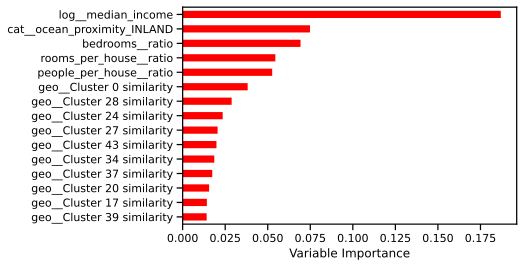

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
#cat_encoder = full_pipeline.named_transformers_["cat"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0])
#attributes = num_attribs + extra_attribs + cat_one_hot_attribs

rel_imp = pd.Series(feature_importances, index=final_model["preprocessing"].get_feature_names_out()).sort_values(inplace=False)
print(rel_imp[-15:])
rel_imp[-15:].T.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others)

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

> Now is also a good time to ensure that your model not only works well on average, but also on all categories of districts, whether they’re rural or urban, rich or poor, northern or southern, minority or not, etc. Creating subsets of your validation set for each category takes a bit of work, but it’s important: if your model performs poorly on a whole category of districts, then it should probably not be deployed until the issue is solved, or at least it should not be used to make predictions for that category, as it may do more harm than good!

## Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. Just get the predictors and the labels from your test set, and run your `final_model` to transform the data and make predictions, then evaluate these predictions:

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is.

For this, you can compute a 95% confidence interval for the generalization error using `scipy.stats.t.interval()`:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

We could compute the interval manually like this:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39275.40861216077, 43467.2768058342)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39276.05610140007, 43466.691749969636)

The performance will usually be slightly worse than what you measured using cross-validation if you did a lot of hyperparameter tuning (**because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets**). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: you need to present your solution highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”). 

In this California housing example, the final performance of the system is not much better than the experts’, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.

# Launch, Monitor, and Maintain Your System

Perfect, you got approval to launch! You now need to get your solution ready for production (e.g., polish the code, write documentation and tests, and so on). Then you can deploy your model to your production environment. 

The most basic way to do this is just to save the best model you trained, transfer the file to your production environment, and load it. To save the model, you can use the `joblib` library like this:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Once your model is transferred to production, you can load it and use it. For this you must first import any custom classes and functions the model relies on (which means transferring the code to production), then load the model using `joblib` and use it to make predictions:

In [ ]:
import joblib

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

For example, perhaps the model will be used within a website: the user will type in some data about a new district and click the Estimate Price button. This will send a query containing the data to the web server, which will forward it to your web application, and finally your code will simply call the model’s `predict()` method (**you want to load the model upon server startup**, rather than every time the model is used). 

Alternatively, you can wrap the model within a dedicated web service that your web application can query through a REST API. This makes it easier to upgrade your model to new versions without interrupting the main application. It also simplifies scaling, since you can start as many web services as needed and load-balance the requests coming from your web application across these web
services. Moreover, it allows your web application to use any language, not just Python.

Another popular strategy is to deploy your model to the cloud, for example on
Google’s Vertex AI (formerly known as Google Cloud AI Platform and Google Cloud
ML Engine): just save your model using `joblib` and upload it to Google Cloud
Storage (GCS), then head over to Vertex AI and create a new model version, pointing it to the GCS file. That’s it! This gives you a simple web service that takes care of load balancing and scaling for you.

It take JSON requests containing the input data (e.g., of a district) and returns JSON responses containing the predictions. You can then use this web service in your website (or whatever production environment you are using). As we will see in model serving lesson that we will use it on AI Platform is not much different from deploying Scikit-Learn models.

But deployment is not the end of the story. You also need to write **monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops**. This could be a steep drop, likely due to a broken component in your infrastructure, but be aware that it could also be a gentle decay that could easily go unnoticed for a long time. This is quite common because models tend to “rot” over time: indeed, the world changes, so if the model was trained with last year’s data, it may not be adapted to today’s data.

## Deployment

So you need to monitor your model’s live performance. But how do you that? Well, it depends. In some cases, the model’s performance can be inferred from **downstream metrics**. For example, if your model is part of a recommender system and it suggests products that the users may be interested in, then it’s easy to monitor the number of recommended products sold each day. If this number drops (compared to non-recommended products), then the prime suspect is the model. This may be because the data pipeline is broken, or perhaps the
model needs to be retrained on fresh data. 

However, it’s not always possible to determine the model’s performance without any human analysis. For example, suppose you trained an image classification model to detect several product defects on a production line. How can you get an alert if the model’s performance drops, before thousands of defective products get shipped to your clients? One solution is to send to human raters a sample of all the pictures that the model classified (especially pictures that the model wasn’t so sure about). Depending on the task, the raters may need to be experts, or they could be nonspecialists, such as workers on a crowdsourcing platform (e.g., Amazon Mechanical Turk). In some applications they could even be the users themselves, responding for example via surveys or repurposed captchas. Either way, you need to put in place a monitoring system (with or without human raters to evaluate the live model), as well as all the relevant processes to define what to do in case of failures and how to prepare for them.

Unfortunately, this can be a lot of work. In fact, **it is often much more work than building and training a model**. If the data keeps evolving, you will need to update your datasets and retrain your model regularly. You should probably automate the whole process as much as possible. Here are a few things you can automate:

* Collect fresh data regularly and label it (e.g., using human raters).
* Write a script to train the model and fine-tune the hyperparameters automatically. This script could run automatically, for example every day or every week, depending on your needs.
* Write another script that will evaluate both the new model and the previous model on the updated test set, and deploy the model to production if the performance has not decreased (if it did, make sure you investigate why). The script should probably test the performance of your model on various subsets of the test set, such as poor or rich districts, rural or urban districts, etc.

You should also make sure **you evaluate the model’s input data quality**. Sometimes performance will degrade slightly because of a poor-quality signal (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale), but it may take a while before your system’s performance degrades enough to trigger an alert. If you monitor your model’s inputs, you may catch this earlier. For example, you could trigger an alert if more and more inputs are missing a feature, or if its mean or standard deviation drifts too far from the training set, or a categorical feature starts containing new categories.

Finally, make sure you keep **backups of every model** you create and have the process and tools in place to roll back to a previous model quickly, in case the new model starts failing badly for some reason. Having backups also makes it possible to easily compare new models with previous ones. Similarly, you should keep backups of every version of your datasets so that you can roll back to a previous dataset if the new one ever gets corrupted (e.g., if the fresh data that gets added to it turns out to be full of outliers). Having backups of your datasets also allows you to evaluate any model against any previous dataset.

As you can see, Machine Learning involves quite a lot of infrastructure, so don’t be surprised if your first ML project takes a lot of effort and time to build and deploy to production. Fortunately, once all the infrastructure is in place, going from idea to production will be much faster.

# Low-code ML using PyCaret

`PyCaret` is a high-level, low-code Python library that makes it easy to compare, train, evaluate, tune, and deploy machine learning models with only a few lines of code. 

At its core, `PyCaret` is basically just a large wrapper over many data science libraries such as `Scikit-learn`, `Yellowbrick`, `SHAP`, `Optuna`, and `Spacy`. Yes, you could use these libraries for the same tasks, but if you don’t want to write a lot of code, PyCaret could save you a lot of time.

https://pycaret.readthedocs.io/en/latest/api/regression.html

In [ ]:
!pip install --pre pycaret[full] -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.1/480.1 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 98.

Remember to restart the notebook to update the modules

## Get the data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

housing = load_housing_data() #Let’s take a look at the top five rows. Each row represents one district. There are 10 attributes
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now that we have the data, we can initialize a `PyCaret` experiment, which will preprocess the data and enable logging for all of the models that we will train on this dataset.

## Explore the data

`ydata-profiling` primary goal is to provide a one-line Exploratory Data Analysis (EDA) experience in a consistent and fast solution. Like pandas `df.describe()` function, that is so handy, `ydata-profiling` delivers an extended analysis of a DataFrame while allowing the data analysis to be exported in different formats such as html and json.

https://github.com/ydataai/ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(housing, title="Profiling Report")

In [ ]:
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

The `setup()` function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. `setup()` must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When `setup()` is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after `setup()` is executed. 

> Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

https://pycaret.gitbook.io/docs/get-started/functions/initialize

In [ ]:
from pycaret.regression import *
exp1 = setup(data = housing, target = 'median_house_value', session_id=123)

,Description,Value
0,Session id,123
1,Target,median_house_value
2,Target type,Regression
3,Original data shape,"(20640, 10)"
4,Transformed data shape,"(20640, 14)"
5,Transformed train set shape,"(14447, 14)"
6,Transformed test set shape,"(6193, 14)"
7,Numeric features,8
8,Categorical features,1
9,Rows with missing values,1.0%


The `eda()` function generates automated Exploratory Data Analysis (EDA) using the `AutoViz` library.

https://pycaret.gitbook.io/docs/get-started/functions/analyze#eda

In [ ]:
eda(display_format = 'bokeh')

Output hidden; open in https://colab.research.google.com to view.

## Prepare the data

In order to demonstrate the `predict_model()` function on unseen data, a sample of 10% records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these records are not available at the time when the machine learning experiment was performed.

In [ ]:
from sklearn.model_selection import train_test_split

housing, data_unseen = train_test_split(housing, test_size=0.1, random_state=42)

https://pycaret.gitbook.io/docs/get-started/preprocessing

In [ ]:
"""
class columnDropperTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 
"""

'\nclass columnDropperTransformer(TransformerMixin):\n    def __init__(self,columns):\n        self.columns=columns\n\n    def transform(self,X,y=None):\n        return X.drop(self.columns,axis=1)\n\n    def fit(self, X, y=None):\n        return self \n'

Note that starting from PyCaret 3.0, it supports OOP API.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# log_experiment = 'wandb',
reg_experiment = setup(housing, 
            target = 'median_house_value', 
            train_size = 0.8,
            data_split_stratify = ['income_cat'],
            numeric_imputation = 'median',
            categorical_imputation = 'mode',
            normalize = True,
            remove_outliers = True,
            #custom_pipeline = columnDropperTransformer(['income_cat_1.0','income_cat_2.0','income_cat_3.0','income_cat_4.0','income_cat_5.0']),
            session_id = 42, 
            #log_experiment=True,
            profile = True,
            experiment_name='ca_housing')

,Description,Value
0,Session id,42
1,Target,median_house_value
2,Target type,Regression
3,Original data shape,"(18576, 11)"
4,Transformed data shape,"(17951, 19)"
5,Transformed train set shape,"(14236, 19)"
6,Transformed test set shape,"(3716, 19)"
7,Numeric features,8
8,Categorical features,2
9,Rows with missing values,1.0%


Loading profile... Please Wait!


In [ ]:
X_train_transformed = get_config("X_train_transformed")

In [ ]:
X_train_transformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,income_cat_2.0,income_cat_1.0,income_cat_3.0,income_cat_4.0,income_cat_5.0
0,-1.364134,1.046776,1.859278,0.197765,0.481069,-0.119739,0.622318,-1.069305,2.901312,-0.374453,-0.909639,-0.682598,-0.014579,1.421609,-0.176182,-0.749410,-0.459495,-0.342352
1,0.702926,-0.861667,0.235242,-0.144908,0.641720,2.210955,0.728542,-0.811247,-0.344672,2.670564,-0.909639,-0.682598,-0.014579,1.421609,-0.176182,-0.749410,-0.459495,-0.342352
3,-0.889063,0.379292,-0.576776,0.403949,0.519485,1.617214,0.614730,-0.619632,-0.344672,-0.374453,1.099337,-0.682598,-0.014579,1.421609,-0.176182,-0.749410,-0.459495,-0.342352
4,0.778736,-0.894571,-0.576776,4.699704,4.252885,4.036448,4.317402,0.354490,-0.344672,-0.374453,1.099337,-0.682598,-0.014579,-0.703428,-0.176182,1.334383,-0.459495,-0.342352
5,0.025697,-0.574930,-0.414373,0.763321,0.376296,0.597698,0.550237,0.781639,-0.344672,2.670564,-0.909639,-0.682598,-0.014579,-0.703428,-0.176182,-0.749410,2.176301,-0.342352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14854,0.192478,-0.664242,0.072838,-0.925360,-0.898438,-0.733011,-0.861027,0.026329,-0.344672,2.670564,-0.909639,-0.682598,-0.014579,-0.703428,-0.176182,1.334383,-0.459495,-0.342352
14855,1.344774,-1.308224,-0.901583,0.901261,0.868728,0.729207,0.975134,-0.624362,-0.344672,-0.374453,1.099337,-0.682598,-0.014579,1.421609,-0.176182,-0.749410,-0.459495,-0.342352
14856,1.238642,-1.275320,-1.145189,-0.385215,-0.884468,-0.584575,-0.815502,2.130376,-0.344672,-0.374453,1.099337,-0.682598,-0.014579,-0.703428,-0.176182,-0.749410,-0.459495,2.920971
14858,0.611955,-0.730051,1.534471,-1.074917,-0.814620,-1.132744,-0.849646,-0.115229,-0.344672,-0.374453,1.099337,-0.682598,-0.014579,-0.703428,-0.176182,1.334383,-0.459495,-0.342352


https://www.kaggle.com/code/uyeanil/titanic-custom-transformer-pipeline-pycaret as AutoML

In [ ]:
"""
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.impute import SimpleImputer

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
        
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
default_num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age
"""

## Select and train a model

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE,R2, RMSLE and MAPE accross the folds (10 by default) along with training time.

https://pycaret.gitbook.io/docs/get-started/functions/train

In [ ]:
best_model = compare_models(sort = 'RMSE', fold=5, verbose=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,30861.9104,2181034968.8429,46691.5909,0.8358,0.2308,0.1717,6.1980
lightgbm,Light Gradient Boosting Machine,32355.3704,2354387054.3994,48510.4899,0.8227,0.2380,0.1806,0.4200
rf,Random Forest Regressor,33150.0424,2572097820.1463,50704.3716,0.8063,0.2444,0.1852,6.1680
et,Extra Trees Regressor,37005.2973,3043882815.8823,55163.1011,0.7707,0.2641,0.2075,4.0100
gbr,Gradient Boosting Regressor,38408.0096,3067882575.8698,55381.6992,0.7690,0.2719,0.2180,2.3660
knn,K Neighbors Regressor,43466.1945,4131793971.2000,64271.9602,0.6888,0.3034,0.2376,0.2460
br,Bayesian Ridge,49242.1016,4720977912.2509,68696.1739,0.6445,0.3801,0.2878,0.2680
ridge,Ridge Regression,49252.5068,4722997394.5170,68710.6807,0.6443,0.3779,0.2880,0.1380
lasso,Lasso Regression,49254.5804,4723361290.9467,68713.2920,0.6443,0.3780,0.2880,0.1860
llar,Lasso Least Angle Regression,49254.4740,4723363267.9404,68713.3056,0.6443,0.3780,0.2880,0.2560


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

The score grid printed above highlights the highest performing metric for comparison purposes only. By passing sort parameter, `compare_models(sort = 'RMSE')` will sort the grid by RMSE (lower to higher since lower is better). We also change the fold parameter from the default value of 10 to a different value by using `compare_models(fold = 5)` which will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, `compare_models` return the best performing model based on default sort order but can be used to return a list of top N models by using `n_select` parameter. Notice that you can also use exclude parameter to block certain models.

There are 25 regressors available in the model library of PyCaret. To see list of all regressors either check the docstring or use `models()` function to see the library.

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPursuit,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


`create_model()` is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

In [ ]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32167.4099,2367963276.0495,48661.7229,0.8085,0.2347,0.1779
1,30984.6322,2126158343.9367,46110.2846,0.8432,0.2215,0.1683
2,32185.5007,2194345568.5475,46843.8424,0.8403,0.2336,0.1781
3,32027.3585,2474181783.1165,49741.1478,0.8163,0.2314,0.1733
4,32129.8307,2404652199.2175,49037.2532,0.8279,0.2486,0.1844
5,31591.5676,2244223522.5267,47373.2364,0.8248,0.2421,0.1823
6,32913.7391,2408284988.0534,49074.2803,0.8144,0.2315,0.1744
7,33253.8539,2476742658.1617,49766.8831,0.8121,0.2603,0.2009
8,30294.3307,2075253002.2693,45554.9449,0.8428,0.2271,0.1742


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
lightgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Fine-Tune your model

https://pycaret.gitbook.io/docs/get-started/functions/optimize

https://pycaret.gitbook.io/docs/get-started/functions/others#automl

https://pycaret.gitbook.io/docs/get-started/functions/optimize#ensemble_model

When a model is created using the create_model function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold. To use the custom search grid, you can pass `custom_grid` parameter in the tune_model function.

In [ ]:
#lgbm_params = {'num_leaves': np.arange(10,200,10),
#                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#                        'learning_rate': np.arange(0.1,1,0.1)
#                        }
tuned_lightgbm = tune_model(lightgbm, n_iter = 20, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32351.2276,2387101345.3071,48857.9712,0.8069,0.2367,0.1792
1,31455.2358,2118511518.6187,46027.2910,0.8438,0.2208,0.1698
2,32328.5698,2238357372.3281,47311.2817,0.8371,0.2347,0.1778
3,31700.3079,2440822708.2834,49404.6831,0.8188,0.2295,0.1688
4,32539.5859,2446707135.0858,49464.2005,0.8249,0.2557,0.1874
5,31239.9483,2198566379.3510,46888.8727,0.8284,0.2394,0.1791
6,32818.6665,2397818205.7179,48967.5219,0.8152,0.2312,0.1741
7,33076.8939,2438819409.6154,49384.4045,0.8149,0.2605,0.1986
8,30685.3025,2109069565.3140,45924.6074,0.8402,0.2293,0.1752


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Analyze the model

Before model finalization, the `plot_model()` function can be used to analyze the performance across different aspects such as Residuals Plot, Prediction Error, Feature Importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

The `evaluate_model()` displays a user interface for analyzing the performance of a trained model. It calls the `plot_model()` function internally.

In [ ]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

https://pycaret.gitbook.io/docs/get-started/functions/analyze

In [ ]:
#plot_model(tuned_lightgbm)
#plot_model(tuned_lightgbm, plot = 'error')
#plot_model(tuned_lightgbm, plot = 'feature')

The `interpret_model()` analyzes the predictions generated from a trained model. Most plots in this function are implemented based on the SHAP (Shapley Additive exPlanations)

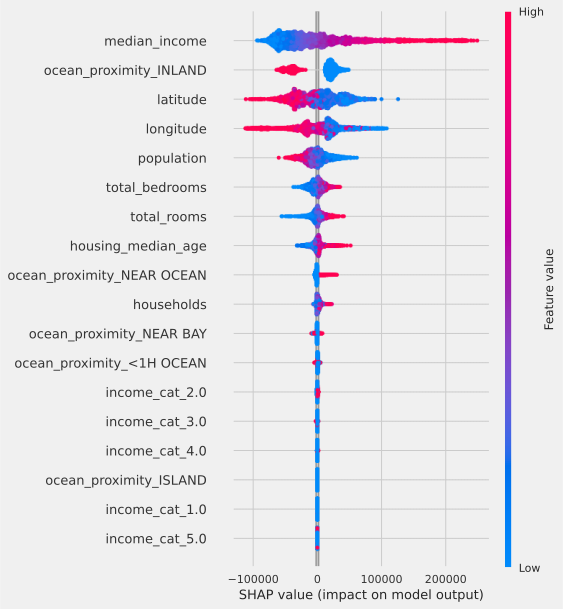

In [ ]:
interpret_model(tuned_lightgbm)

## Predict on test set

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics.

In [ ]:
predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,32502.7734,2287056237.8276,47823.1768,0.8326,0.2390,0.1826


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,median_house_value,prediction_label
14860,-117.650002,34.020000,9.0,2107.0,411.0,1138.0,389.0,4.4042,INLAND,3,159100.0,166584.740965
14861,-117.680000,34.150002,4.0,4082.0,578.0,1996.0,580.0,6.7813,INLAND,5,286300.0,263679.509928
14862,-118.290001,34.080002,23.0,1864.0,937.0,2795.0,858.0,1.8495,<1H OCEAN,2,212500.0,212056.088491
14863,-117.970001,33.990002,23.0,3335.0,570.0,1560.0,555.0,5.7268,<1H OCEAN,4,300300.0,271747.627121
14864,-117.320000,34.099998,42.0,801.0,176.0,711.0,183.0,1.8681,INLAND,2,59700.0,65521.582721
...,...,...,...,...,...,...,...,...,...,...,...,...
18571,-121.000000,37.259998,45.0,1750.0,371.0,847.0,354.0,1.7062,INLAND,2,77400.0,89862.446840
18572,-122.169998,37.720001,43.0,3783.0,814.0,2139.0,789.0,4.0202,NEAR BAY,3,166300.0,196701.827793
18573,-117.120003,32.580002,34.0,2003.0,466.0,1226.0,443.0,3.0613,NEAR OCEAN,3,136700.0,135883.426084
18574,-122.040001,38.250000,52.0,582.0,131.0,241.0,106.0,2.4000,INLAND,2,125000.0,130034.478754


## Finalize model

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with `setup()`, followed by comparing all models using `compare_models()` and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The `finalize_model()` function fits the model onto the complete dataset including the test/hold-out sample (20% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [ ]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [ ]:
predict_model(final_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,29413.3892,1872817647.7416,43276.0632,0.8629,0.2199,0.1665


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,median_house_value,prediction_label
14860,-117.650002,34.020000,9.0,2107.0,411.0,1138.0,389.0,4.4042,INLAND,3,159100.0,162164.238793
14861,-117.680000,34.150002,4.0,4082.0,578.0,1996.0,580.0,6.7813,INLAND,5,286300.0,273877.534930
14862,-118.290001,34.080002,23.0,1864.0,937.0,2795.0,858.0,1.8495,<1H OCEAN,2,212500.0,209148.262865
14863,-117.970001,33.990002,23.0,3335.0,570.0,1560.0,555.0,5.7268,<1H OCEAN,4,300300.0,277503.747233
14864,-117.320000,34.099998,42.0,801.0,176.0,711.0,183.0,1.8681,INLAND,2,59700.0,63081.895276
...,...,...,...,...,...,...,...,...,...,...,...,...
18571,-121.000000,37.259998,45.0,1750.0,371.0,847.0,354.0,1.7062,INLAND,2,77400.0,93080.033327
18572,-122.169998,37.720001,43.0,3783.0,814.0,2139.0,789.0,4.0202,NEAR BAY,3,166300.0,193502.069024
18573,-117.120003,32.580002,34.0,2003.0,466.0,1226.0,443.0,3.0613,NEAR OCEAN,3,136700.0,130554.077380
18574,-122.040001,38.250000,52.0,582.0,131.0,241.0,106.0,2.4000,INLAND,2,125000.0,111131.581617


The `predict_model()` function is also used to predict on the unseen dataset.  `data_unseen` is the variable created at the beginning of the tutorial and contains 10% of the original dataset which was never exposed to PyCaret

In [ ]:
data_unseen["income_cat"] = pd.cut(data_unseen["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,32474.6118,2364513076.8764,48626.2591,0.8164,0.2404,0.1824


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,median_house_value,prediction_label
0,-122.379997,40.669998,10.0,2281.0,444.0,1274.0,438.0,2.2120,INLAND,2,65600.0,68770.661309
1,-118.370003,33.830002,35.0,1207.0,207.0,601.0,213.0,4.7308,<1H OCEAN,4,353400.0,316812.741266
2,-117.239998,32.720001,39.0,3089.0,431.0,1175.0,432.0,7.5925,NEAR OCEAN,5,466700.0,442420.543218
3,-118.440002,34.049999,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,<1H OCEAN,3,500001.0,431798.750579
4,-118.440002,34.180000,33.0,2127.0,414.0,1056.0,391.0,4.3750,<1H OCEAN,3,286100.0,262450.257792


In [ ]:
from pycaret.utils.generic import check_metric
check_metric(unseen_predictions.median_house_value, unseen_predictions.prediction_label, 'RMSE')

48626.2591

## Save and load the model

We have now finished the experiment by finalizing the `tuned_lightgbm` model which is now stored in `final_lightgbm` variable. We have also used the model stored in `final_lightgbm` to predict `data_unseen`. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function `save_model()` allows you to save the model along with entire transformation pipeline for later use.

In [ ]:
save_model(final_lightgbm,'Final LightGBM Model 02Feb2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['longitude', 'latitude',
                                              'housing_median_age',
                                              'total_rooms', 'total_bedrooms',
                                              'population', 'households',
                                              'median_income'],
                                     transformer=SimpleImputer(strategy='median'))),
                 ('categorical_imputer',
                  TransformerWrapper(include=['ocean_proximity', 'income_cat...
                  TransformerWrapper(include=['ocean_proximity', 'income_cat'],
                                     transformer=OneHotEncoder(cols=['ocean_proximity',
                                                                     'income_cat'],
                                                               handle_missing='return_nan',
    

To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's `load_model()` function and then easily apply the saved model on new unseen data for prediction.

In [ ]:
saved_final_lightgbm = load_model('Final LightGBM Model 02Feb2022')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
new_prediction = predict_model(saved_final_lightgbm, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,32474.6118,2364513076.8764,48626.2591,0.8164,0.2404,0.1824


In [ ]:
from pycaret.utils.generic import check_metric
check_metric(new_prediction.median_house_value, new_prediction.prediction_label, 'RMSE')

48626.2591

# Deplpy

https://pycaret.gitbook.io/docs/get-started/functions/deploy

https://pycaret.gitbook.io/docs/get-started/functions/others#get_config

In [ ]:
create_app(final_lightgbm)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
# deploy a model
# deploy_model(final_lightgbm, model_name = 'final_lightgbm', platform = 'gcp', authentication = {'project': 'gcp-project-name', 'bucket' : 'gcp-bucket-name'})